In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.metrics as metrics
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV

In [2]:
df = pd.read_csv('./kaggle_data/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Cleaning Up the Data
1. Converting categorical cols, rating cols, and continuous cols to a format an ML model can read
2. Splitting this data 80-20 for testing purposes
3. Removing NaNs

In [3]:
# These are the manually picked columns that are all categorical
total_categorical_cols = ['MSZoning', 'Street', 'Alley', 'LandContour', 
                    'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
                    'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
                    'ExterCond', 'Foundation', 'Heating', 'CentralAir', 'PavedDrive',
                    'MiscFeature', 'SaleType', 'SaleCondition']

# These columns will have to be manually processed
total_rating_cols = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 
                   'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                  'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
                    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']

#########
# Below will be the columns actually used in the model
#########

exclude_cols = ['Id', 'SalePrice']

category_cols = total_categorical_cols.copy()
rating_cols = total_rating_cols.copy()
continuous_cols = [col for col in df.columns if col not in category_cols and col not in rating_cols and col not in exclude_cols]

In [4]:
# Take rating columns and convert to numerical scale
rating_df = df.copy()[rating_cols]

replace_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1,
               'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4,
               'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1,
               'Gtl': 1, 'Mod': 2, 'Sev': 3,
               'NA': 0,
               'Av': 3, 'Mn': 2, 'No': 1,
               'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1,
               'SBrkr': 5, 'FuseA': 4, 'FuseF': 3, 'FuseP': 2, 'Mix': 1,
               'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1,
               '2Types': 6, 'Attchd': 5, 'Basment': 4, 'BuiltIn': 3, 'CarPort': 2, 'Detchd': 1,
               'Fin': 3, 'RFn': 2, 'Unf': 1,
               'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1}

rating_df.replace(replace_dict, inplace=True)

na_to_zero_cols = ['LotShape', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                  'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCond', 'GarageQual',
                   'PoolQC', 'Fence', 'Electrical']

na_to_zero_cols = [col for col in na_to_zero_cols if col in rating_df]

rating_df[na_to_zero_cols] = rating_df.loc[:, na_to_zero_cols].fillna(0)

In [5]:
# Select categorical columns and get dummy column values (different approach from what we did before with category type)
# Preferably pick columns that are not like rating columns (Bad, Okay, Great). We should handle those separately
dummy_df = pd.get_dummies(df[category_cols])

In [6]:
YVar = df[['SalePrice']]
XVar = pd.concat([df[continuous_cols], dummy_df, rating_df], axis=1)

# Filter out nan values
YVar = YVar[XVar.notna().all(axis='columns')]
XVar = XVar[XVar.notna().all(axis='columns')]

# TODO GO BACK AND FIGURE OUT WHERE ALL THESE NANS ARE COMING FROM
print('Num rows after filtering out nans: ' + str(len(XVar)))
print('Percent remaining after filtering: ' + str(round(len(XVar) / len(df) * 100)) + '%')

XVar = XVar.apply(pd.to_numeric)

Num rows after filtering out nans: 1121
Percent remaining after filtering: 77%


In [7]:
# Split data 80-20 so we can test how well the model works
msk = np.random.rand(len(XVar)) < 0.8

train_x = XVar[msk]
train_y = YVar[msk]

test_x = XVar[~msk]
test_y = YVar[~msk]

print(train_x.shape)

(903, 220)


# Recursive Feature Elimination with Crossfold Validation
1. Determines optimal number of features to use from our dataset
2. Produce which columns these are
3. Show the graph of how accuracy increases as number of selected features rises
4. Produce rfecv_train_x

In [8]:
# Try doing recursive feature elimination with crossfold validation
svr = SVR(kernel="linear")
rfecv = RFECV(estimator=svr, cv=5, step=5, min_features_to_select=30)
rfecv.fit(train_x, np.array(train_y).ravel())

#print(rfecv.ranking_)

rfecv_feature_mask = rfecv.get_support()
rfecv_features = []

for b, feature in zip(rfecv_feature_mask, train_x.columns):
    if b: 
        rfecv_features.append(feature)

rfecv_train_x = train_x[rfecv_features].copy()
rfecv_test_x = test_x[rfecv_features].copy()

rfecv_train_x

,MSSubClass,LotFrontage,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,...,BsmtExposure,BsmtFinType2,HeatingQC,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,Fence
0,60,65.0,7,5,2003,2003,196.0,706,856,856,...,1.0,1.0,5,4,8,0.0,5.0,2.0,3.0,0.0
1,20,80.0,6,8,1976,1976,0.0,978,1262,1262,...,4.0,1.0,5,3,8,3.0,5.0,2.0,3.0,0.0
3,70,60.0,7,5,1915,1970,0.0,216,756,961,...,1.0,1.0,4,4,8,4.0,1.0,1.0,3.0,0.0
4,60,84.0,8,5,2000,2000,350.0,655,1145,1145,...,3.0,1.0,5,4,8,3.0,5.0,2.0,3.0,0.0
5,50,85.0,5,5,1993,1995,0.0,732,796,796,...,1.0,1.0,5,3,8,0.0,5.0,1.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,20,78.0,8,5,2008,2009,194.0,0,1573,1578,...,1.0,1.0,5,5,8,4.0,5.0,3.0,3.0,0.0
1452,180,35.0,5,5,2005,2005,80.0,547,547,1072,...,4.0,1.0,4,3,8,0.0,4.0,3.0,3.0,0.0
1455,60,62.0,6,5,1999,2000,0.0,0,953,953,...,1.0,1.0,5,3,8,3.0,5.0,2.0,3.0,0.0
1458,20,68.0,5,6,1950,1996,0.0,49,1078,1078,...,2.0,3.0,4,4,8,0.0,5.0,1.0,3.0,0.0


Optimal number of features: 75


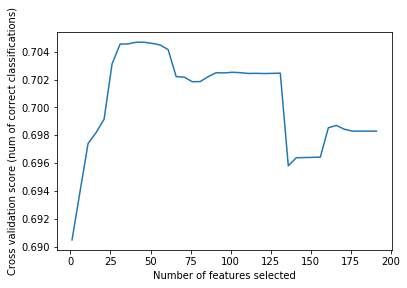

In [22]:
print("Optimal number of features: %d" % rfecv.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (num of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) * 5 + 1, 5), rfecv.grid_scores_)
plt.show()

In [20]:
print(len(rfecv_features))
print(rfecv_features)

75
['MSSubClass', 'LotFrontage', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'ScreenPorch', 'MoSold', 'YrSold', 'MSZoning_FV', 'MSZoning_RM', 'Neighborhood_BrkSide', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Feedr', 'Condition1_Norm', 'BldgType_Duplex', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin', 'RoofStyle_Gable', 'RoofStyle_Hip', 'Exterior1st_BrkFace', 'Exterior1st_HdBoard', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior2nd_HdBoard', 'Exterior2nd_MetalSd', 'Exterior2nd_Plywood', 'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone', 'Foundation_BrkTil', 'Foundation_C

In [23]:
print(rfecv.grid_scores_)

[0.69049165 0.6939714  0.69741447 0.69819357 0.69915702 0.70313335
 0.70455    0.70456382 0.70468207 0.70468237 0.7045996  0.70448772
 0.7041511  0.70221386 0.70217939 0.70184947 0.70185747 0.70221408
 0.70249413 0.70247955 0.70252656 0.7025002  0.7024428  0.7024507
 0.70243517 0.70244747 0.7024631  0.69581241 0.69639366 0.69640242
 0.69641864 0.69643655 0.69854269 0.69871248 0.69843514 0.69830247
 0.69830247 0.69830247 0.69830247]


# Run Linear Regression and Perform Analysis
1. Create model on univariate/rfecv data
2. Test model on test_x dataset
3. View results, average difference, residuals

In [12]:
# Run linear regression with sklearn
regr = linear_model.LinearRegression()
regr.fit(rfecv_train_x, train_y)

# Make predictions using the testing set, then convert to pandas series
saleprice_preds = regr.predict(rfecv_test_x)
saleprice_preds = pd.Series([x for lst in saleprice_preds for x in lst])

# Print out coefficient information
#print('Coefficients: \n', regr.coef_)
r2 = metrics.r2_score(test_y, saleprice_preds)
print('r2: ', round(r2,4))

r2:  0.8463


In [13]:
# Construct the results dataframe
actual_price = test_y.reset_index()['SalePrice']
pred_price = saleprice_preds.round()

res = pd.DataFrame({'actual_price': actual_price, 'predicted_price': pred_price})
res

,actual_price,predicted_price
0,223500,202696.0
1,139000,146683.0
2,139400,151802.0
3,129900,120577.0
4,134800,142403.0
...,...,...
213,127500,136871.0
214,142000,171823.0
215,185000,200456.0
216,210000,215048.0


In [14]:
res['residual'] = res.actual_price - res.predicted_price
res['percent_diff'] = (res['residual'] / res.actual_price * 100).round(decimals=2)
res

,actual_price,predicted_price,residual,percent_diff
0,223500,202696.0,20804.0,9.31
1,139000,146683.0,-7683.0,-5.53
2,139400,151802.0,-12402.0,-8.90
3,129900,120577.0,9323.0,7.18
4,134800,142403.0,-7603.0,-5.64
...,...,...,...,...
213,127500,136871.0,-9371.0,-7.35
214,142000,171823.0,-29823.0,-21.00
215,185000,200456.0,-15456.0,-8.35
216,210000,215048.0,-5048.0,-2.40


In [15]:
print('Average percent_difference: %.2f' % (res.percent_diff.abs().mean()))

Average percent_difference: 11.41


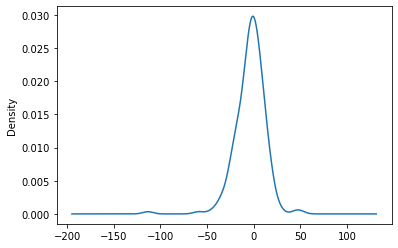

In [16]:
res.percent_diff.plot.kde()

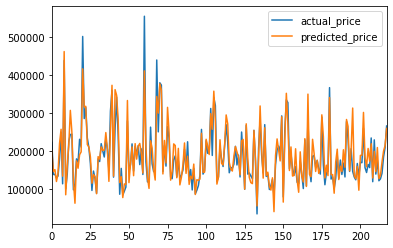

In [17]:
# Predicted price is actually really close to actual, but not when actual price is very very high
res.plot(kind='line', y=['actual_price', 'predicted_price'])

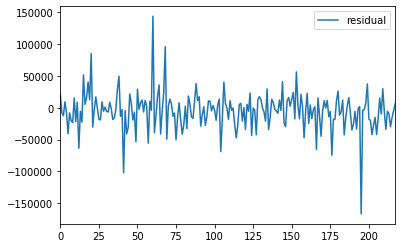

In [18]:
res.plot(kind='line', y='residual')